# New approach - Quantification of Mtb area per iAT2/iAT1/iPSDM for DAPI_ZO-1_CD16_Mtb images

#### Using the max projection of the ZO1 to segment a relatively uniform monolayer and then localise and track. 

#### Load modules, define functions and parameters

In [22]:
import napari
from skimage import io
import btrack
import os
from tqdm.auto import tqdm
import numpy as np
import btrack
from glob import glob
from homuncu_loc.dataio import find_files_with_basename, ID_extractor
from macrohet.notify import send_sms
from cellpose import core, utils, models, metrics
import matplotlib.pyplot as plt 
from skimage.morphology import remove_small_objects

# print gpu information
!nvcc --version
!nvidia-smi
# check to see if GPU can be used
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# define segmentation model parameters
model = models.Cellpose(gpu=use_GPU, 
                        model_type='cyto') # cytoplasmic segmentation 
channels = [0,0] # this means using a grayscale image for both nuclei and cyto channels (even if not using nuclei, still have to say its same colour [greyscale = 0])

def segment_channel(segmentation_channel, diameter=60, flow_threshold=0.99, channels=[0,0], cellprob_threshold=-2, min_mask_size=500, return_diams=False, start_point=None, end_point=None):
    """
    Segments a specified channel of an image using Cellpose and optionally returns the average diameter of segments.

    Args:
    - segmentation_channel (ndarray): 3D array of the target channel where the 3rd dimension represents the Z-stack.
    - diameter (int, optional): Average cell diameter for Cellpose. Default is 60.
    - flow_threshold (float, optional): Threshold for flow in Cellpose. Default is 0.99.
    - channels (list, optional): Channel input for Cellpose. Default is [0,0].
    - cellprob_threshold (float, optional): Cell probability threshold for Cellpose. Default is -2.
    - min_mask_size (int, optional): Minimum size of objects to keep in the segmented mask. Default is 500.
    - return_diams (bool, optional): If set to True, the function will also return the average diameter of segments.
    - start_point (int, optional): Starting point for segmentation frames. Default is None.
    - end_point (int, optional): Ending point for segmentation frames. Default is None.

    Returns:
    - ndarray: 3D mask array with the same shape as the input, where segmented regions are labeled.
    - float (optional): Average diameter of segments if return_diams is True.
    """
    # Initialize the model
    model = models.Cellpose(model_type='cyto')

    # check if segmenting over max proj
    if segmentation_channel.ndim == 2:
        print('segmenting over max projection')
        # Segment over selected frames
        masks, _, _, diam = model.eval(segmentation_channel, diameter=diameter, flow_threshold=flow_threshold, channels=channels, cellprob_threshold=cellprob_threshold)
        masks = remove_small_objects(masks, min_size=min_mask_size)
        
        if return_diams:
            return masks, diam
        else:
            return masks
        
    if start_point is None or end_point is None:
        # Calculate intensities for each frame in Z-stack
        intensities = [np.sum(frame) for frame in tqdm(segmentation_channel, desc='finding where segmentation channel is expressed in Z')]

        # Estimate the background level
        background_level = np.min(intensities)
        threshold = background_level + ((np.max(intensities)-np.min(intensities))*0.50)

        if start_point is None:
            # Find the points where the curve starts to deviate from the background
            start_point = np.argmax(intensities > threshold)

        if end_point is None:
            end_point = len(intensities) - np.argmax(intensities[::-1] > threshold) - 1

    # Initialize output mask array
    mask_array = np.zeros_like(segmentation_channel)
    
    # List to store diameters if return_diams is True
    diams = []

    # Segment over selected frames
    for n, frame in tqdm(enumerate(segmentation_channel[start_point:end_point]), total=end_point-start_point, desc='segmenting over select frames'):
        n += start_point
        masks, _, _, diam = model.eval(frame, diameter=diameter, flow_threshold=flow_threshold, channels=channels, cellprob_threshold=cellprob_threshold)
        masks = remove_small_objects(masks, min_size=min_mask_size)
        mask_array[n] = masks
        diams.append(diam)
        print(f'Frame {n} segmented')

    if return_diams:
        return mask_array, diams
    else:
        return mask_array


# from stardist.models import StarDist2D
# from csbdeep.utils import normalize
# import matplotlib.pyplot as plt

# # prints a list of available models
# StarDist2D.from_pretrained()

# # creates a pretrained model
# stardist_model = StarDist2D.from_pretrained('2D_versatile_fluo')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon Dec  4 11:59:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 30%   42C    P2              76W / 300W |   1971MiB / 49140MiB |      8%      D

In [2]:
props = ('axis_major_length', # first define some cell properties 
         'axis_minor_length', # this helps improve the tracking
         'eccentricity',      # by comparing similarities between slices/frames
         'area', 
         'orientation',
         'mean_intensity', 
        )

In [23]:
image_basenames = ['20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1561.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1565.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1559.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1569.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1558.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1555.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1570.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1562.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1572.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1560.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1564.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1557.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1563.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1571.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1567.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1566.tif',
 '20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1568.tif',
 '20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1553.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1544.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1551.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1545.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1546.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1547.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1552.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1542.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1541.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1543.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1549.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1550.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1540.tif',
 '20231127_20X_23-03-072A5_DAPI_ZO-1_CD16_Mtb_ATG14KO_2hpi_Multichannel Z-Stack_20231127_1554.tif',
 '20231127_20X_23-03-072A6_DAPI_ZO-1_CD16_Mtb_ATG14KO_48hpi_Mult...nel Z-Stack_20231127_1548.tif']

In [25]:
for n, i in enumerate(image_basenames):
    print(n,':', i)

0 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1561.tif
1 : 20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1565.tif
2 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1559.tif
3 : 20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1569.tif
4 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1558.tif
5 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1555.tif
6 : 20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1570.tif
7 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1562.tif
8 : 20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_Mtb_WT_48hpi_Multichannel Z-Stack_20231128_1572.tif
9 : 20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1560.tif
10 : 20231128_20X_23-03-072A4_DAPI_ZO-1_CD16_M

In [26]:
basedir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/images'

In [27]:
image_fns = [os.path.join(basedir, fn) for fn in image_basenames]

# Inspect some sample images

In [219]:
%%time
fn = [fn for fn in image_fns if '1556' in fn][0]
images = io.imread(fn)

CPU times: user 2.2 s, sys: 8.06 s, total: 10.3 s
Wall time: 2min 1s


In [220]:
fn

'/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/images/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556.tif'

In [221]:
images.shape

(155, 2304, 2304, 4)

In [222]:
viewer = napari.Viewer(title = os.path.basename(fn))

viewer.add_image(images, channel_axis = -1)



[<Image layer 'Image' at 0x7efddb4ae4f0>,
 <Image layer 'Image [1]' at 0x7f0776db1ca0>,
 <Image layer 'Image [2]' at 0x7f0776d5d100>,
 <Image layer 'Image [3]' at 0x7f0776d0bca0>]

In [224]:
print()

# Manualy segmentation

In [225]:
masks = viewer.layers['Labels'].data

In [226]:
np.save(f'mask_backup_{ID_extractor(fn)}.npy', masks)

In [227]:
%%time 
# work on seperate volume in case masks get acc overwritten
z_volume = masks

# Initialize a new 3D array
linked_masks = np.zeros_like(z_volume)

# Identify all unique cell IDs (excluding 0 as it usually represents background)
unique_cells = np.unique(z_volume[z_volume > 0])

# Iterate over each cell ID
for cell_id in tqdm(unique_cells, total = len(unique_cells)):
    
    # Find all z-indices where this cell ID appears
    z_indices = np.unique(np.where(z_volume == cell_id)[0])

    # Check if there are at least two instances
    if len(z_indices) > 1:
        
        # iterate over each step between successive manually created masks
        for step in tqdm(range(len(z_indices)-1), desc = f'Iterating over cell ID {cell_id} GT masks', total = (len(z_indices)-1), leave = False):

            # find the first and next z indices that this mask appears in 
            first_z, next_z = z_indices[step], z_indices[step+1]

            # iterate over the frames in this range 
            for z in tqdm(range(first_z, next_z), desc = 'Filling in the gaps', total = len(range(first_z, next_z)), leave = False):
                
                # change the next frame to feature the mask of cell ID from the current frame
                linked_masks[z+1][z_volume[first_z] == cell_id] = cell_id


  0%|          | 0/54 [00:00<?, ?it/s]

Iterating over cell ID 1 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/35 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating over cell ID 2 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/24 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/11 [00:00<?, ?it/s]

Iterating over cell ID 3 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/40 [00:00<?, ?it/s]

Iterating over cell ID 4 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/32 [00:00<?, ?it/s]

Iterating over cell ID 5 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/37 [00:00<?, ?it/s]

Iterating over cell ID 6 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/30 [00:00<?, ?it/s]

Iterating over cell ID 7 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/64 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/11 [00:00<?, ?it/s]

Iterating over cell ID 8 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/32 [00:00<?, ?it/s]

Iterating over cell ID 9 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/38 [00:00<?, ?it/s]

Iterating over cell ID 10 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/21 [00:00<?, ?it/s]

Iterating over cell ID 11 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/13 [00:00<?, ?it/s]

Iterating over cell ID 12 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/9 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over cell ID 13 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/20 [00:00<?, ?it/s]

Iterating over cell ID 14 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/31 [00:00<?, ?it/s]

Iterating over cell ID 15 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/22 [00:00<?, ?it/s]

Iterating over cell ID 16 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/28 [00:00<?, ?it/s]

Iterating over cell ID 17 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/31 [00:00<?, ?it/s]

Iterating over cell ID 18 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/26 [00:00<?, ?it/s]

Iterating over cell ID 19 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/26 [00:00<?, ?it/s]

Iterating over cell ID 20 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/32 [00:00<?, ?it/s]

Iterating over cell ID 21 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/23 [00:00<?, ?it/s]

Iterating over cell ID 22 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/23 [00:00<?, ?it/s]

Iterating over cell ID 23 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/23 [00:00<?, ?it/s]

Iterating over cell ID 24 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/14 [00:00<?, ?it/s]

Iterating over cell ID 25 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/14 [00:00<?, ?it/s]

Iterating over cell ID 26 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/23 [00:00<?, ?it/s]

Iterating over cell ID 27 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over cell ID 28 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/19 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/18 [00:00<?, ?it/s]

Iterating over cell ID 29 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/42 [00:00<?, ?it/s]

Iterating over cell ID 30 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/25 [00:00<?, ?it/s]

Iterating over cell ID 31 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/33 [00:00<?, ?it/s]

Iterating over cell ID 32 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/22 [00:00<?, ?it/s]

Iterating over cell ID 33 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/26 [00:00<?, ?it/s]

Iterating over cell ID 34 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/48 [00:00<?, ?it/s]

Iterating over cell ID 35 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/38 [00:00<?, ?it/s]

Iterating over cell ID 36 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/41 [00:00<?, ?it/s]

Iterating over cell ID 37 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/15 [00:00<?, ?it/s]

Iterating over cell ID 38 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/33 [00:00<?, ?it/s]

Iterating over cell ID 39 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/31 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/8 [00:00<?, ?it/s]

Iterating over cell ID 40 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/25 [00:00<?, ?it/s]

Iterating over cell ID 41 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/27 [00:00<?, ?it/s]

Iterating over cell ID 42 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/24 [00:00<?, ?it/s]

Iterating over cell ID 43 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/25 [00:00<?, ?it/s]

Iterating over cell ID 44 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/31 [00:00<?, ?it/s]

Iterating over cell ID 45 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/14 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/18 [00:00<?, ?it/s]

Iterating over cell ID 46 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/24 [00:00<?, ?it/s]

Iterating over cell ID 47 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/36 [00:00<?, ?it/s]

Iterating over cell ID 48 GT masks:   0%|          | 0/3 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/24 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/9 [00:00<?, ?it/s]

Iterating over cell ID 49 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over cell ID 50 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/21 [00:00<?, ?it/s]

Iterating over cell ID 51 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/16 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/5 [00:00<?, ?it/s]

Iterating over cell ID 52 GT masks:   0%|          | 0/2 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/11 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/17 [00:00<?, ?it/s]

Iterating over cell ID 53 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/23 [00:00<?, ?it/s]

Iterating over cell ID 54 GT masks:   0%|          | 0/1 [00:00<?, ?it/s]

Filling in the gaps:   0%|          | 0/49 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 6.94 s, total: 2min 22s
Wall time: 2min 22s


In [228]:
viewer.add_labels(linked_masks)

<Labels layer 'linked_masks' at 0x7efdcdf83940>

In [229]:
np.save(f'united_mask_backup_{ID_extractor(fn)}.npy', linked_masks)

In [230]:
output_mask_fn = fn.replace('images', 'sc_analyses').replace('.tif', '_mphi_gt_masks.h5')

In [231]:
output_mask_fn

'/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_iVEC_macrophage_experiments/DAPI_ZO1_CD16_MTB/sc_analyses/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5'

In [234]:
with btrack.io.HDF5FileHandler('/home/dayn/analysis/homuncu_loc/segmentation_and_tracking/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5', 'w', obj_type='obj_type_1') as writer:
        # writer.write_tracks(tracks)
        writer.write_segmentation(masks)

[INFO][2023/12/05 10:09:26 am] Opening HDF file: /home/dayn/analysis/homuncu_loc/segmentation_and_tracking/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5...
[INFO][2023/12/05 10:09:35 am] Closing HDF file: /home/dayn/analysis/homuncu_loc/segmentation_and_tracking/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5


In [235]:
with btrack.io.HDF5FileHandler('/home/dayn/analysis/homuncu_loc/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5', 'r', obj_type='obj_type_1') as reader:
        # writer.write_tracks(tracks)
        seg = reader.segmentation

[INFO][2023/12/05 10:10:43 am] Opening HDF file: /home/dayn/analysis/homuncu_loc/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5...
[INFO][2023/12/05 10:10:48 am] Loading segmentation (155, 2304, 2304)
[INFO][2023/12/05 10:10:48 am] Closing HDF file: /home/dayn/analysis/homuncu_loc/20231128_20X_23-03-072A3_DAPI_ZO-1_CD16_Mtb_WT_2hpi_Multichannel Z-Stack_20231128_1556_mphi_gt_masks.h5


In [236]:
viewer.add_labels(seg)

<Labels layer 'seg' at 0x7efdcd885cd0>

In [237]:
print()

### Iteratively check images

In [7]:
for i, fn in tqdm(enumerate(image_fns), total = len(image_fns)):
   
    images = io.imread(fn)
    viewer = napari.Viewer(title = os.path.basename(fn))
    
    viewer.add_image(images, channel_axis = -1)
    viewer.show(block=True)

  0%|          | 0/34 [00:00<?, ?it/s]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


# Test segment

/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


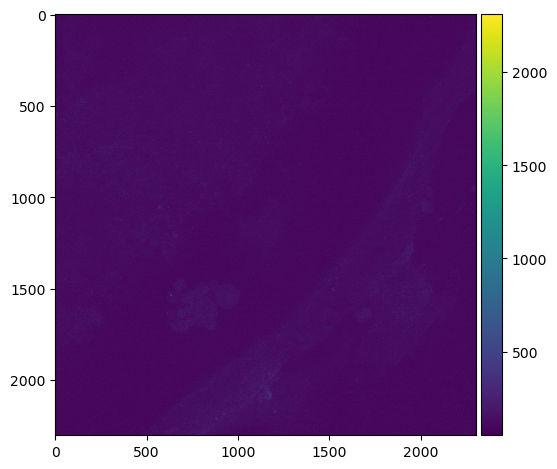

In [13]:
cd16_frame = images[40, ..., 2]
io.imshow(cd16_frame)

In [15]:
masks, _, _, diam = model.eval(cd16_frame, channels=[0,0])# diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)

In [24]:
masks = segment_channel(cd16_frame, diameter = None, )

segmenting over max projection


/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/cellpose/plot.py:43: RuntimeWarning: overflow encountered in square
  mag = np.clip(transforms.normalize99(np.sqrt(np.sum(dP**2,axis=0))), 0, 1.)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/cellpose/plot.py:58: RuntimeWarning: invalid value encountered in cast
  im = (np.clip(im, 0, 1) * 255).astype(np.uint8)


In [19]:
viewer = napari.Viewer()

viewer.add_image(cd16_frame)
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7f07a9841a90>

In [18]:

io.imsave('test_cd16_frame.tiff', cd16_frame)


/tmp/ipykernel_675763/1756969031.py:1: UserWarning: test_cd16_frame.tiff is a low contrast image
  io.imsave('test_cd16_frame.tiff', cd16_frame)


# Run over images and label

In [35]:
# Iterate over a list of image file paths using tqdm for progress tracking
for image_fn in tqdm(image_fns, total=len(image_fns), desc='iterating over image volumes'):

    # Define the output filename
    output_fn = image_fn.replace('images', 'sc_analyses').replace('.tif', '_iat2.h5').replace('/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/', 
                                                                                         '/home/dayn/data/homuncu_loc_temp/seperate_tracks/')
    # if os.path.exists(output_fn):
    #     continue
    
    try:
        # Read the image using imageio.imread
        image = io.imread(image_fn)
    except Exception as e:
        # Code to handle the exception and print the error message
        print(e)
        continue

    
    # # Extract the third channel (mphi_channel) from the image
    # mphi_channel = image[..., 2]
    
    # # Segment the mphi_channel using custom function 'segment_channel'
    # mphi_masks, mphi_diams = segment_channel(
    #     mphi_channel,
    #     diameter=60,
    #     flow_threshold=0.99,
    #     channels=[0, 0],
    #     cellprob_threshold=-2,
    #     min_mask_size=200,
    #     return_diams=True,
    #     start_point=None,
    #     end_point=None
    # )

    # # update
    # send_sms(f'mphi seg done {ID_extractor(image_fn)}')
    
    # Extract the second channel (zo1_channel) from the image
    zo1_channel = image[..., -1]

    # Compress the zo1 channel down to be a max projection
    zo1_channel = np.max(zo1_channel, axis=0)
    
    # Segment the zo1_channel for iat2 using 'segment_channel' with specific parameters
    iat2_masks, iat2_diams = segment_channel(
        zo1_channel,
        diameter=None,
        flow_threshold=0,
        channels=[0, 0],
        cellprob_threshold=0,
        min_mask_size=200,
        return_diams=True,
        start_point=None,
        end_point=None
    )
    masks = iat2_masks
    masks = np.stack([masks for i in range(len(image))], axis = 0)
    # update
    send_sms(f'iat2 seg done {ID_extractor(image_fn)}')

    
    # # Segment the zo1_channel for iat1 using 'segment_channel' with specific parameters
    # iat1_masks, iat1_diams = segment_channel(
    #     zo1_channel,
    #     diameter=150,
    #     flow_threshold=0.99,
    #     channels=[0, 0],
    #     cellprob_threshold=-3,
    #     min_mask_size=2500,
    #     return_diams=True,
    #     start_point=None,
    #     end_point=None
    # )
    
    # # update
    # send_sms(f'iat1 seg done {ID_extractor(image_fn)}')
    
    # # Loop over three different mask types: mphi_masks, iat2_masks, iat1_masks
    # for n, masks in tqdm(enumerate([mphi_masks, iat2_masks, iat1_masks]), total=3):
        
    # Convert the segmentation masks to objects using btrack
    objects = btrack.utils.segmentation_to_objects(
        segmentation=iat2_masks,
        intensity_image=image,
        properties=props,
        use_weighted_centroid=False,
        assign_class_ID=True,
    )

    # update
    # send_sms(f'object localisation {n, ID_extractor(image_fn)} done')

    
    # Check if mtb infected above threshold and measure mtb properties for each cell
    threshold = 230
    mtb_ch = 3
    
    for o in tqdm(objects, desc='Measuring Mtb properties of each cell'):
        coordinates = np.argwhere(masks[o.t] == o.properties['class_id'])
        pixel_values = image[o.t, coordinates[:, 0], coordinates[:, 1]]
        mtb_status = np.any(pixel_values[:,mtb_ch] > threshold)
        mtb_area = np.sum(pixel_values[:,mtb_ch] > threshold)
        o.properties['mtb_status'] = mtb_status
        o.properties['mtb_area'] = mtb_area
        # o.properties['pixel_values'] = pixel_values

    # update
    # send_sms(f'mtb props {n, ID_extractor(image_fn)} done')

    # Initialize BayesianTracker
    with btrack.BayesianTracker() as tracker:
        
        # Configure the tracker using a config file
        tracker.configure('/home/dayn/analysis/models/loc.json')
        
        # Set max search radius to a very limited radius
        tracker.max_search_radius = 5
        
        # Define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        
        # Use visual features to track
        tracker.features = props
        
        # Append the objects to be tracked
        tracker.append(objects)
        
        # Set the volume
        tracker.volume = ((0, masks.shape[1]), (0, masks.shape[2]), (-1e5, 1e5))
        
        # Track them (in interactive mode)
        tracker.track(step_size=10)
        
        # Generate hypotheses and run the global optimizer
        tracker.optimize()
        
        # Get the tracks as a Python list
        tracks = tracker.tracks

    # update
    # send_sms(f'tracking {n, ID_extractor(image_fn)} done')

    # # Define the output filename
    # output_fn = image_fn.replace('images', 'sc_analyses').replace('.tif', '_iat2.h5').replace('/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/', 
    #                                                                                      '/home/dayn/data/homuncu_loc_temp/seperate_tracks/')
    os.makedirs(os.path.dirname(output_fn), exist_ok=True)
    
    # Define the object type based on the iteration index
    obj_type = f'obj_type_{2}'


    # Write the tracks and segmentation masks to an HDF5 file using btrack.io.HDF5FileHandler
    with btrack.io.HDF5FileHandler(output_fn, 'w', obj_type=obj_type) as writer:
        writer.write_tracks(tracks)
        writer.write_segmentation(masks)

    # update 


iterating over image volumes:   0%|          | 0/1 [00:00<?, ?it/s]

segmenting over max projection


[INFO][2023/10/20 02:32:36 PM] Localizing objects from segmentation...


Update sms failed to send


progress:   0%|                                                       | 0/2304 [00:00<?, ?it/s]


ValueError: Segmentation array must have 3 or 4 dims.

In [33]:
masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [34]:
masks.shape

(61, 2304, 2304)